# Simple Model of the LNG Market

The object of this model is to minimize total LNG costs while satisfying constraints on the supplies available at each of the exporting nodes, and satisfying demand requirements at each of the importing nodes.

In [32]:
import shutil
import sys
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chart_studio
import chart_studio.plotly as py
from tabulate import tabulate
plt.close('all')

from IPython.display import display
from geopy.geocoders import Nominatim
from geopy import distance
from pyomo.environ import *

geolocator = Nominatim(user_agent="Your_Name")
pd.set_option('precision', 3)
MMBtu_LNG = 21.04 # 1m³ of LNG = 21.04MMBtu
MMBtu_Gas = 0.036 # 1m³ of Gas = 0.036MMBtu
LNG_to_Gas = 584 # 1m³ of LNG = 584m³ of gas (http://www.lngplants.com/conversiontables.html)

## 1 Data 

### 1.1 Importing Nodes

Ten largest importing countries according to "BP Stats Review (2020)" are taken into consideration. Each importing node has volume of imported LNG as an attribute.

In [35]:
# Data for importing and exporting countries from "BP Stats Review (2020)"

# "Import (MMBtu)" column consists of imports in m³ multiplied with conversion factor

Imp_Countries = pd.DataFrame({
    
    "Country" : ["Japan", "China", "South Korea", "India", "France", "Spain",
                 "UK", "Italy", "Turkey", "Belgium"],
    
     "Import (MMBtu)" : [105.5*10**9 * MMBtu_Gas, 84.8*10**9 * MMBtu_Gas, 55.6*10**9 * MMBtu_Gas,
                         32.9*10**9 * MMBtu_Gas, 22.9*10**9 * MMBtu_Gas, 21.9*10**9 * MMBtu_Gas,
                         18*10**9 * MMBtu_Gas, 13.5*10**9 * MMBtu_Gas, 12.9*10**9 * MMBtu_Gas,
                         7.2*10**9 * MMBtu_Gas],
    
    "Regasification Terminal" : ["Sodegaura", "Yancheng", "Incheon", "Dahej", "Dunkirk",
                     "Barcelona", "Isle of Grain", "Rovigo", "Marmara", "Zeebrugge"]
})

#Imp_Countries["Import (MMBtu)"] = (Imp_Countries["Import (MMBtu)"].astype(float)/1000000000).astype(str)


# getting the coordinates of largest regas terminals, not neccesarry anymore, since there is no suitable package
# for calculating sea distances and the API's are not free of charge:(

Imp_Countries["Location"] = Imp_Countries["Regasification Terminal"].apply(geolocator.geocode)
Imp_Countries["Point"]= Imp_Countries["Location"].apply(lambda loc: tuple(loc.point) if loc else None)
Imp_Countries[["Latitude", "Longitude", "Altitude"]] = pd.DataFrame(Imp_Countries["Point"].to_list(), index=Imp_Countries.index)

del Imp_Countries["Altitude"]
del Imp_Countries["Location"]
del Imp_Countries["Point"]


#center the columns, display() method doesn't work anymore, so not necessary for now
def pd_centered(df):
    return df.style.set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}])

Imp_Countries.style

,Country,Import (MMBtu),Regasification Terminal,Latitude,Longitude
0,Japan,3798000000.000,Sodegaura,35.430,139.954
1,China,3052800000.000,Yancheng,33.350,120.158
2,South Korea,2001600000.000,Incheon,37.456,126.705
3,India,1184400000.000,Dahej,21.712,72.590
4,France,824400000.000,Dunkirk,51.035,2.377
5,Spain,788400000.000,Barcelona,41.383,2.177
6,UK,648000000.000,Isle of Grain,51.454,0.695
7,Italy,486000000.000,Rovigo,44.977,12.274
8,Turkey,464400000.000,Marmara,40.972,28.669
9,Belgium,259200000.000,Zeebrugge,51.334,3.195


### 1.2 Exporting Nodes

Ten largest exporting countries according to "BP Stats Review (2020)" are taken into consideration. Each exporting node has volume of exported LNG and break even price (feedstock price + liquefaction price) as attributes.

In [36]:
# define DF with data for exporting countries (BP 2020)

Exp_Countries = pd.DataFrame({
    
    "Country" : ["Qatar", "Australia", "USA", "Russia", "Malaysia", "Nigeria",
                 "Trinidad & Tobago", "Algeria", "Indonesia","Oman"],
    
    "Export (MMBtu)" : [107.1*10**9 * MMBtu_Gas, 104.7*10**9 * MMBtu_Gas, 47.5*10**9 * MMBtu_Gas,
                        39.4*10**9 * MMBtu_Gas, 35.1*10**9 * MMBtu_Gas, 28.8*10**9 * MMBtu_Gas,
                        17.0*10**9 * MMBtu_Gas, 16.9*10**9 * MMBtu_Gas, 16.5*10**9 * MMBtu_Gas,
                        14.1*10**9 * MMBtu_Gas],
    
    "Break Eeven Price ($/MMBtu)" : [2.5, 6.5, 6.0, 4.5, 6.0, 4.08, 5.1, 2.5, 6.0, 3.5],
    
    #"Feedstock ($/MMBtu)" : [0.5, 3.0, 3.0, 0.5, 3.0, 2.2, 3.0, 0.5, 2.0, 1.5],

    #"Liquefaction ($/MMBtu)" : [2.0, 3.5, 3.0, 4.0, 3.0, 1.88, 2.1, 2.0, 4.0, 2.0],
    
    "Liquefaction Terminal" : ["Ras Laffan", "Gladstone", "Sabine Pass", "Sabetta",
                               "Bintulu", "Bonny Island", "Point Fortin",
                               " Bethioua", "Bontang", "Qalhat"],
})

#Exp_Countries["Export (Bcm)"] = (Exp_Countries["Export (Bcm)"].astype(float)/1000000000).astype(str)


# Getting the coordinates of liquefaction terminals, not neccesarry anymore, since there is no suitable package
# for calculating sea distances and the API's are not free of charge:(

Exp_Countries["Location"] = Exp_Countries["Liquefaction Terminal"].apply(geolocator.geocode)
Exp_Countries["Point"] = Exp_Countries["Location"].apply(lambda loc: tuple(loc.point) if loc else None)
Exp_Countries[["Latitude", "Longitude", "Altitude"]] = pd.DataFrame(Exp_Countries["Point"].to_list(), index=Exp_Countries.index)

# remove unnecessary columns
del Exp_Countries["Altitude"]
del Exp_Countries["Location"]
del Exp_Countries["Point"]

#display(pd_centered(Exp_Countries))
Exp_Countries.style

,Country,Export (MMBtu),Break Eeven Price ($/MMBtu),Liquefaction Terminal,Latitude,Longitude
0,Qatar,3855600000.000,2.500,Ras Laffan,25.898,51.533
1,Australia,3769200000.000,6.500,Gladstone,-23.843,151.256
2,USA,1710000000.000,6.000,Sabine Pass,29.733,-93.896
3,Russia,1418400000.000,4.500,Sabetta,71.236,72.127
4,Malaysia,1263600000.000,6.000,Bintulu,3.187,113.047
5,Nigeria,1036800000.000,4.080,Bonny Island,4.456,7.243
6,Trinidad & Tobago,612000000.000,5.100,Point Fortin,10.174,-61.672
7,Algeria,608400000.000,2.500,Bethioua,35.806,-0.268
8,Indonesia,594000000.000,6.000,Bontang,0.124,117.472
9,Oman,507600000.000,3.500,Qalhat,34.358,35.783


### 1.3 Sea distances among the importing and exporting nodes

In [4]:
# Define DF with distances among largest liquefaction and regas terminals in nautical miles
# In case of lack of route to the specific terminal, next largest port was taken
# sea-distances.org, searoutes.com

# if route over canal: distance rounded on 0 for suez and on 5 for panama, needed for later calculations

Distances = pd.DataFrame([(6512, 5846, 6161, 1301, 6240, 4650, 6260, 4380, 3460, 6270),
                          
                          (3861, 4134, 4313, 5918, 11650, 10060, 11670, 9790, 8870, 11680),
                          
                          (9205, 10075, 10005, 9645, 4881, 5206, 4897, 6354, 6341, 4908),
                          
                          (4929, 5596, 5671, 10160, 2494, 4252, 2511, 5546, 5481, 2477),
                          
                          (2276, 1656, 1998, 3231, 8980, 7390, 9000, 7120, 6200, 9010),
                          
                          (10752, 10088, 10406, 6988, 4287, 3824, 4309, 4973, 4961, 4321),
                          
                          (8885, 9755, 9665, 8370, 3952, 3926, 3974, 5074, 5062, 3984),
                          
                          (9590, 8930, 9240, 4720, 1519, 343, 1541, 1432, 1417, 1552),
                          
                          (2651, 2181, 2487, 3517, 9260, 7670, 9280, 7390, 6470, 9290),
                          
                          (6046, 5379, 5694, 853, 5760, 4180, 5790, 3900, 2980, 5800)

                         ],

                  index=["Qatar", "Australia", "USA", "Russia", "Malaysia", 
                         "Nigeria", "Trinidad & Tobago", "Algeria", "Indonesia"
                         ,"Oman"],

                  columns = ("Japan", "China", "South Korea", "India", "France",
                             "Spain", "UK", "Italy", "Turkey", "Belgium"))

#display(pd_centered(Distances))
Distances

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,6512,5846,6161,1301,6240,4650,6260,4380,3460,6270
Australia,3861,4134,4313,5918,11650,10060,11670,9790,8870,11680
USA,9205,10075,10005,9645,4881,5206,4897,6354,6341,4908
Russia,4929,5596,5671,10160,2494,4252,2511,5546,5481,2477
Malaysia,2276,1656,1998,3231,8980,7390,9000,7120,6200,9010
Nigeria,10752,10088,10406,6988,4287,3824,4309,4973,4961,4321
Trinidad & Tobago,8885,9755,9665,8370,3952,3926,3974,5074,5062,3984
Algeria,9590,8930,9240,4720,1519,343,1541,1432,1417,1552
Indonesia,2651,2181,2487,3517,9260,7670,9280,7390,6470,9290
Oman,6046,5379,5694,853,5760,4180,5790,3900,2980,5800


### 1.4 LNG Carrier

To keep the model simple it is assumed that there is only one type of the LNG carrier with the following characteristics:
 - Capacity: 160000 m³
 - Spot Charter Rate: 70000 \\$/day
 - Average speed: 17 knots/h
 - Boil off: 0.1% 
 - Heel: 4%

In [37]:
# define DF with lng carrier properties

LNG_Carrier = pd.DataFrame({"Capacity (m³)" : [160000], # average capacity in 2019 160000 (!!! https://www.rivieramm.com/opinion/opinion/lng-shipping-by-numbers-36027)
                            "Spot Charter Rate ($/day)" : [70000], # average spot charter rate in 2019
                            "Speed (knots/h)" : [17],
                            "Bunker (mt/d)" : [110], # !!! Does boil off reduce it and what's the ratio then??? 
                            "Bunkers Price ($/mt)" : [670], 
                            "Boil off" : [1/1000], # the daily guaranteed maximum boil-off or DGMB (0,1%)
                            "Heel" : [4/100]}) # 4% of the cargo is retained as the heel (LNG storage tanks need to be kept cool)

#print(LNG_Carrier_DF.loc[0, "Capacity (m³)"])
#display(pd_centered(LNG_Carrier))
LNG_Carrier.style

,Capacity (m³),Spot Charter Rate ($/day),Speed (knots/h),Bunker (mt/d),Bunkers Price ($/mt),Boil off,Heel
0,160000,70000,17,110,670,0.001,0.040


### 1.5 Additional Costs

- Port costs for 3 days (outbound port, destination port and one day in case it has to wait for loading/unloading): 300000 \\$
- Canal Fees (Suez or Panama Canal): 1000000 \\$ and 900000 \\$ respectively
- Agents and broker fees: 2% of charter cost plus
- Insurance: 2,600 $/day

In [38]:
# define DF containing additional costs

Additional_Costs = pd.DataFrame({
    "Port Costs ($ for 3 days)" : [300000], 
    "Suez Canal Costs ($/Cargo)" : [1000000],  # 0.24 $/mmBtU
    "Panama Canal Costs ($/Cargo)" : [900000], # 0.21 $/mmBtu,                     
    "Insurance ($/day)" : [2600],
    "Fees (Percentage of Charter Costs)" : [2/100]})

#display(pd_centered(Additional_Costs))
Additional_Costs.style

,Port Costs ($ for 3 days),Suez Canal Costs ($/Cargo),Panama Canal Costs ($/Cargo),Insurance ($/day),Fees (Percentage of Charter Costs)
0,300000,1000000,900000,2600,0.020


## 2 Cost and voyage times calculations

### 2.1 (Return) Voyage Times

In [7]:
Time = Distances / (LNG_Carrier.loc[0, "Speed (knots/h)"] * 12) # in days

# note to myself: it would be better to define a function which would compute the time!!!
#display(pd_centered(Time))
Time

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,31.922,28.657,30.201,6.377,30.588,22.794,30.686,21.471,16.961,30.735
Australia,18.926,20.265,21.142,29.010,57.108,49.314,57.206,47.990,43.480,57.255
USA,45.123,49.387,49.044,47.279,23.926,25.520,24.005,31.147,31.083,24.059
Russia,24.162,27.431,27.799,49.804,12.225,20.843,12.309,27.186,26.868,12.142
Malaysia,11.157,8.118,9.794,15.838,44.020,36.225,44.118,34.902,30.392,44.167
Nigeria,52.706,49.451,51.010,34.255,21.015,18.745,21.123,24.377,24.319,21.181
Trinidad & Tobago,43.554,47.819,47.377,41.029,19.373,19.245,19.480,24.873,24.814,19.529
Algeria,47.010,43.775,45.294,23.137,7.446,1.681,7.554,7.020,6.946,7.608
Indonesia,12.995,10.691,12.191,17.240,45.392,37.598,45.490,36.225,31.716,45.539
Oman,29.637,26.368,27.912,4.181,28.235,20.490,28.382,19.118,14.608,28.431


### 2.2 Charter Costs

In [39]:
Charter_Costs = (Time + 2) * LNG_Carrier.loc[0, "Spot Charter Rate ($/day)"] # in $

# display(pd_centered(Charter_Costs))
Charter_Costs.style

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,2374509.804,2145980.392,2254068.627,586421.569,2281176.471,1735588.235,2288039.216,1642941.176,1327254.902,2291470.588
Australia,1464852.941,1558529.412,1619950.980,2170686.275,4137549.020,3591960.784,4144411.765,3499313.725,3183627.451,4147843.137
USA,3298578.431,3597107.843,3573088.235,3449558.824,1814852.941,1926372.549,1820343.137,2320294.118,2315833.333,1824117.647
Russia,1831323.529,2060196.078,2085931.373,3626274.510,995784.314,1599019.608,1001617.647,2043039.216,2020735.294,989950.980
Malaysia,920980.392,708235.294,825588.235,1248676.471,3221372.549,2675784.314,3228235.294,2583137.255,2267450.980,3231666.667
Nigeria,3829411.765,3601568.627,3710686.275,2537843.137,1611029.412,1452156.863,1618578.431,1846421.569,1842303.922,1622696.078
Trinidad & Tobago,3188774.510,3487303.922,3456421.569,3012058.824,1496078.431,1487156.863,1503627.451,1881078.431,1876960.784,1507058.824
Algeria,3430686.275,3204215.686,3310588.235,1759607.843,661225.490,257696.078,668774.510,631372.549,626225.490,672549.020
Indonesia,1049656.863,888382.353,993382.353,1346813.725,3317450.980,2771862.745,3324313.725,2675784.314,2360098.039,3327745.098
Oman,2214607.843,1985735.294,2093823.529,432696.078,2116470.588,1574313.725,2126764.706,1478235.294,1162549.020,2130196.078


### 2.3 Fuel Costs

In [9]:
# this is arbitrary cost (it should be taken either price after relequifaction or destination hub price)
lng_cost = 5 # $/MMBtu 

Fuel_Costs = Time * LNG_Carrier.loc[0, "Boil off"] * 0.98 * LNG_Carrier.loc[0, "Capacity (m³)"] * lng_cost * MMBtu_LNG

# this is arbitrary cost (it should be taken either price after relequifaction or destination hub price)
lng_cost = 5 # $/MMBtu 

#display(pd_centered(Fuel_Costs))
Fuel_Costs

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,526557.766,472705.267,498176.044,105198.350,504563.953,375997.176,506181.145,354165.082,279774.243,506989.741
Australia,312198.946,334273.619,348747.489,478527.159,942014.431,813447.655,943631.624,791615.561,717224.722,944440.220
USA,744312.690,814660.549,809000.376,779890.918,394675.746,420955.118,395969.500,513781.948,512730.773,396858.955
Russia,398557.007,452490.365,458554.836,821533.616,201663.862,343815.053,203038.475,448447.385,443191.511,200289.249
Malaysia,184036.467,133903.511,161557.496,261257.393,726119.278,597552.502,727736.471,575720.408,501329.569,728545.067
Nigeria,869402.504,815711.724,841425.079,565046.940,346645.139,309207.140,348424.050,402114.830,401144.515,349394.365
Trinidad & Tobago,718437.616,788785.475,781508.110,676794.918,319557.170,317454.820,321336.082,410281.650,409311.335,322144.678
Algeria,775443.639,722076.298,747142.776,381657.349,122825.744,27734.845,124604.656,115790.958,114578.064,125494.111
Indonesia,214358.820,176354.805,201097.845,284383.241,748759.969,620193.192,750377.161,597552.502,523161.663,751185.757
Oman,488877.189,434943.831,460414.607,68973.245,465751.341,337993.161,468177.129,315352.471,240961.631,468985.725


### 2.4 Agents and Broker Fees + Insurance

In [10]:
Fees_and_Insurance = (Time + 2) * Additional_Costs.loc[0, "Insurance ($/day)"] + Charter_Costs * Additional_Costs.loc[0, "Fees (Percentage of Charter Costs)"]

#display(pd_centered(Fees_and_Insurance))
Fees_and_Insurance

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,135686.275,122627.451,128803.922,33509.804,130352.941,99176.471,130745.098,93882.353,75843.137,130941.176
Australia,83705.882,89058.824,92568.627,124039.216,236431.373,205254.902,236823.529,199960.784,181921.569,237019.608
USA,188490.196,205549.020,204176.471,197117.647,103705.882,110078.431,104019.608,132588.235,132333.333,104235.294
Russia,104647.059,117725.490,119196.078,207215.686,56901.961,91372.549,57235.294,116745.098,115470.588,56568.627
Malaysia,52627.451,40470.588,47176.471,71352.941,184078.431,152901.961,184470.588,147607.843,129568.627,184666.667
Nigeria,218823.529,205803.922,212039.216,145019.608,92058.824,82980.392,92490.196,105509.804,105274.510,92725.490
Trinidad & Tobago,182215.686,199274.510,197509.804,172117.647,85490.196,84980.392,85921.569,107490.196,107254.902,86117.647
Algeria,196039.216,183098.039,189176.471,100549.020,37784.314,14725.490,38215.686,36078.431,35784.314,38431.373
Indonesia,59980.392,50764.706,56764.706,76960.784,189568.627,158392.157,189960.784,152901.961,134862.745,190156.863
Oman,126549.020,113470.588,119647.059,24725.490,120941.176,89960.784,121529.412,84470.588,66431.373,121725.490


### 2.5 Suez/Panama Canal Fee

In [11]:
# create empty data frames for canal fees and port costs
Canal_Fees = pd.DataFrame(np.zeros((10,10)),
                   
                    index = ["Qatar", "Australia", "USA", "Russia", "Malaysia", 
                             "Nigeria", "Trinidad & Tobago", "Algeria", "Indonesia",
                             "Oman"],

                    columns = ("Japan", "China", "South Korea", "India", "France",
                               "Spain", "UK", "Italy", "Turkey", "Belgium"))

for index in Distances.index:
    for columns in Distances.columns:
        if (((Distances.loc[index, columns]) % 5 == 0) and ((Distances.loc[index, columns]) %10 != 0)):
            Canal_Fees.loc[index, columns] += Additional_Costs.loc[0, "Panama Canal Costs ($/Cargo)"]
        elif ((Distances.loc[index, columns]) % 10 == 0):
            Canal_Fees.loc[index, columns] += Additional_Costs.loc[0, "Suez Canal Costs ($/Cargo)"]
            
#display(pd_centered(Canal_Fees))
Canal_Fees

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,0.0,0.0,0.0,0.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
Australia,0.0,0.0,0.0,0.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
USA,900000.0,900000.0,900000.0,900000.0,0.0,0.0,0.0,0.0,0.0,0.0
Russia,0.0,0.0,0.0,1000000.0,0.0,0.0,0.0,0.0,0.0,0.0
Malaysia,0.0,0.0,0.0,0.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
Nigeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Trinidad & Tobago,900000.0,900000.0,900000.0,1000000.0,0.0,0.0,0.0,0.0,0.0,0.0
Algeria,1000000.0,1000000.0,1000000.0,1000000.0,0.0,0.0,0.0,0.0,0.0,0.0
Indonesia,0.0,0.0,0.0,0.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
Oman,0.0,0.0,0.0,0.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0


### 2.6 Port Costs

In [12]:
# empty data frame for port costs
Port_Costs = pd.DataFrame(np.zeros((10,10)),
                   
                    index = ["Qatar", "Australia", "USA", "Russia", "Malaysia", 
                             "Nigeria", "Trinidad & Tobago", "Algeria", "Indonesia",
                             "Oman"],

                    columns = ("Japan", "China", "South Korea", "India", "France",
                               "Spain", "UK", "Italy", "Turkey", "Belgium"))

Port_Costs += Additional_Costs.loc[0, "Port Costs ($ for 3 days)"]

#display(pd_centered(Port_Costs))
Port_Costs

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
Australia,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
USA,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
Russia,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
Malaysia,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
Nigeria,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
Trinidad & Tobago,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
Algeria,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
Indonesia,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
Oman,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0


### 2.7 Total Costs of Transportation

In [41]:
Transport_Costs =  Charter_Costs + Fuel_Costs + Fees_and_Insurance + Canal_Fees + Port_Costs
#Transport_Costs

Transport_Costs_MMBtu = Transport_Costs / (0.94 * LNG_Carrier.loc[0, "Capacity (m³)"] * MMBtu_LNG) # 1-heel-boil_off = 0.94

#display(pd_centered(Transport_Costs_MMBtu))
Transport_Costs_MMBtu.style #in $/MMBtu

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,1.054,0.961,1.005,0.324,1.332,1.109,1.335,1.072,0.943,1.337
Australia,0.683,0.721,0.746,0.971,2.091,1.868,2.094,1.830,1.701,2.095
USA,1.716,1.838,1.829,1.778,0.826,0.871,0.828,1.032,1.030,0.830
Russia,0.833,0.926,0.937,1.882,0.491,0.738,0.494,0.919,0.910,0.489
Malaysia,0.461,0.374,0.422,0.595,1.716,1.494,1.719,1.456,1.327,1.721
Nigeria,1.649,1.556,1.600,1.121,0.743,0.678,0.746,0.839,0.837,0.747
Trinidad & Tobago,1.672,1.793,1.781,1.631,0.696,0.692,0.699,0.853,0.851,0.700
Algeria,1.802,1.709,1.753,1.119,0.355,0.190,0.358,0.342,0.340,0.359
Indonesia,0.513,0.447,0.490,0.635,1.756,1.533,1.759,1.494,1.365,1.760
Oman,0.989,0.896,0.940,0.261,1.265,1.044,1.269,1.004,0.875,1.271


### 2.8 Total Costs

Total cost per unit of transported LNG = Feedstock Price + Liquefaction Cost + Total Cost of Transportation

In [40]:
# taken from EXP_Countries df

Breakeven = pd.DataFrame([(2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5),
                          
                        (6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5),
                          
                        (6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0),
                          
                        (4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5),
                          
                        (6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0),
                          
                        (4.08, 4.08, 4.08, 4.08, 4.08, 4.08, 4.08, 4.08, 4.08, 4.08),
                          
                        (5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1),
                          
                        (2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5),
                          
                        (6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0),
                          
                        (3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5)

                       ],

                  index = ["Qatar", "Australia", "USA", "Russia", "Malaysia", "Nigeria",
                           "Trinidad & Tobago", "Algeria", "Indonesia","Oman"],

                  columns = ("Japan", "China", "South Korea", "India", "France",
                             "Spain", "UK", "Italy", "Turkey", "Belgium"))

Total_Costs = Breakeven + Transport_Costs_MMBtu

#display(pd_centered(Total_Costs))
Total_Costs.style # in $/MMBtu

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,3.554,3.461,3.505,2.824,3.832,3.609,3.835,3.572,3.443,3.837
Australia,7.183,7.221,7.246,7.471,8.591,8.368,8.594,8.330,8.201,8.595
USA,7.716,7.838,7.829,7.778,6.826,6.871,6.828,7.032,7.030,6.830
Russia,5.333,5.426,5.437,6.382,4.991,5.238,4.994,5.419,5.410,4.989
Malaysia,6.461,6.374,6.422,6.595,7.716,7.494,7.719,7.456,7.327,7.721
Nigeria,5.729,5.636,5.680,5.201,4.823,4.758,4.826,4.919,4.917,4.827
Trinidad & Tobago,6.772,6.893,6.881,6.731,5.796,5.792,5.799,5.953,5.951,5.800
Algeria,4.302,4.209,4.253,3.619,2.855,2.690,2.858,2.842,2.840,2.859
Indonesia,6.513,6.447,6.490,6.635,7.756,7.533,7.759,7.494,7.365,7.760
Oman,4.489,4.396,4.440,3.761,4.765,4.544,4.769,4.504,4.375,4.771


## 3 Optimization Model

The aim of the model is to calculate the optimal distribution of a commodity from a set of exporters to a set of importers in such a way that the overall costs are minimal, while satisfying constraints on the supplies available at each of the exporters, and satisfying demand requirements at each of the importers.

**After the shippments between each exporting and importing node are calculated the hub price in importing country can be determinated following the merrit order effect: the shippment with highest price per unit of LNG is also the hub price. (Is this correct???)**



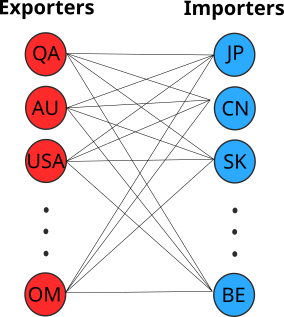

The situation can be modeled by links connecting a set of nodes representing exporters to a set of nodes representing importers. For each link there is a parameter TC[e,i] denoting the total cost per MMBtu of the transported LNG over the link. A non-negative decision variable x[e,i] represents the volume of shipped LNG over the link.

Objective function:

$$minimize:     Cost = \sum_{e\in Exporters}\sum_{i\in Importers}TC[e,i]x[e,i]$$

Constraints:

- All shipments from an exporting node can not exceed the export volume of that exporting node:

$$ \sum_{e\in Exporters}x[e,i] \leq Export[e] ,        \forall e \in Exporters$$ 

- Shipments to each importing node must satisfy their demand.

$$ \sum_{i\in Importers}x[e,i] = Import[i]  ,          \forall i \in Importers$$

### 3.1 Data File

In [15]:
# Extract "Countries", "Exports" and "Imports" from "Exp_Countries" and "Imp_Countries" dfs
# and create dictionaries

Supply = Exp_Countries.set_index("Country")["Export (MMBtu)"].to_dict()
#print(Supply)

Demand = Imp_Countries.set_index("Country")["Import (MMBtu)"].to_dict()
#print(Demand)

# I would really like to get "Cost" dictionary straight from the "Total_Costs" df, since doing it 
# this way is real pain in the ...
Cost = {
    ("Japan", "Qatar"): 3.473,
    ("China", "Qatar"): 3.387,
    ("South Korea", "Qatar"): 3.428,
    ("India", "Qatar"): 2.797,
    ("France", "Qatar"): 3.725,
    ("Spain", "Qatar"): 3.519,
    ("UK", "Qatar"): 3.728,
    ("Italy", "Qatar"): 3.484,
    ("Turkey", "Qatar"): 3.364,
    ("Belgium", "Qatar"): 3.729,
    ("Japan", "Australia"): 7.129,
    ("China", "Australia"): 7.165,
    ("South Korea", "Australia"): 7.188,
    ("India", "Australia"): 7.396,
    ("France", "Australia"): 8.427,
    ("Spain", "Australia"): 8.220,
    ("UK", "Australia"): 8.429,
    ("Italy", "Australia"): 8.185,
    ("Turkey", "Australia"): 8.066,
    ("Belgium", "Australia"): 8.430,
    ("Japan", "USA"): 7.581,
    ("China", "USA"): 7.694,
    ("South Korea", "USA"): 7.685,
    ("India", "USA"): 7.638,
    ("France", "USA"): 6.762,
    ("Spain", "USA"): 6.804,
    ("UK", "USA"): 6.764,
    ("Italy", "USA"): 6.953,
    ("Turkey", "USA"): 6.951,
    ("Belgium", "USA"): 6.765,
    ("Japan", "Russia"): 5.268,
    ("China", "Russia"): 5.354,
    ("South Korea", "Russia"): 5.364,
    ("India", "Russia"): 6.233,
    ("France", "Russia"): 4.952,
    ("Spain", "Russia"): 5.180,
    ("UK", "Russia"): 4.954,
    ("Italy", "Russia"): 5.348,
    ("Turkey", "Russia"): 5.339,
    ("Belgium", "Russia"): 4.950,
    ("Japan", "Malaysia"): 6.424,
    ("China", "Malaysia"): 6.343,
    ("South Korea", "Malaysia"): 6.388,
    ("India", "Malaysia"): 6.548,
    ("France", "Malaysia"): 7.580,
    ("Spain", "Malaysia"): 7.374,
    ("UK", "Malaysia"): 7.583,
    ("Italy", "Malaysia"): 7.339,
    ("Turkey", "Malaysia"): 7.220,
    ("Belgium", "Malaysia"): 7.584,
    ("Japan", "Nigeria"): 5.603,
    ("China", "Nigeria"): 5.517,
    ("South Korea", "Nigeria"): 5.558,
    ("India", "Nigeria"): 5.115,
    ("France", "Nigeria"): 4.765,
    ("Spain", "Nigeria"): 4.705,
    ("UK", "Nigeria"): 4.767,
    ("Italy", "Nigeria"): 4.854,
    ("Turkey", "Nigeria"): 4.852,
    ("Belgium", "Nigeria"): 4.769,
    ("Japan", "Trinidad & Tobago"): 6.639,
    ("China", "Trinidad & Tobago"): 6.752,
    ("South Korea", "Trinidad & Tobago"): 6.740,
    ("India", "Trinidad & Tobago"): 6.601,
    ("France", "Trinidad & Tobago"): 5.741,
    ("Spain", "Trinidad & Tobago"): 5.738,
    ("UK", "Trinidad & Tobago"): 5.744,
    ("Italy", "Trinidad & Tobago"): 5.887,
    ("Turkey", "Trinidad & Tobago"): 5.885,
    ("Belgium", "Trinidad & Tobago"): 5.745,
    ("Japan", "Algeria"): 4.159,
    ("China", "Algeria"): 4.074,
    ("South Korea", "Algeria"): 4.114,
    ("India", "Algeria"): 3.528,
    ("France", "Algeria"): 2.826,
    ("Spain", "Algeria"): 2.673,
    ("UK", "Algeria"): 2.828,
    ("Italy", "Algeria"): 2.814,
    ("Turkey", "Algeria"): 2.812,
    ("Belgium", "Algeria"): 2.830, 
    ("Japan", "Indonesia"): 6.472,
    ("China", "Indonesia"): 6.411,
    ("South Korea", "Indonesia"): 6.451,
    ("India", "Indonesia"): 6.585,
    ("France", "Indonesia"): 7.617,
    ("Spain", "Indonesia"): 7.410,
    ("UK", "Indonesia"): 7.619,
    ("Italy", "Indonesia"): 7.374,
    ("Turkey", "Indonesia"): 7.255,
    ("Belgium","Indonesia"): 7.620,
    ("Japan", "Oman"): 4.413,
    ("China", "Oman"): 4.326,
    ("South Korea", "Oman"): 4.367,
    ("India", "Oman"): 3.739,
    ("France", "Oman"): 4.663,
    ("Spain", "Oman"): 4.458,
    ("UK", "Oman"): 4.667,
    ("Italy", "Oman"): 4.421,
    ("Turkey", "Oman"): 4.302,
    ("Belgium", "Oman"): 4.668    
}

#print(Cost)

### 3.1 Model File

In [16]:
# Step 0: Create an instance of the model
model = ConcreteModel()
model.dual = Suffix(direction=Suffix.IMPORT)

# Step 1: Define index sets
CUS = list(Demand.keys()) # Customer
SRC = list(Supply.keys()) # Source

# Step 2: Define the decision 
model.x = Var(CUS, SRC, domain = NonNegativeReals)

# Step 3: Define Objective
model.Cost = Objective(
    expr = sum([Cost[c,s]*model.x[c,s] for c in CUS for s in SRC]),
    sense = minimize)

# Step 4: Constraints
model.src = ConstraintList()
for s in SRC:
    model.src.add(sum([model.x[c,s] for c in CUS]) <= Supply[s])
        
model.dmd = ConstraintList()
for c in CUS:
    model.dmd.add(sum([model.x[c,s] for s in SRC]) == Demand[c])
    
results = SolverFactory('glpk').solve(model)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 69384718800.0
  Upper bound: 69384718800.0
  Number of objectives: 1
  Number of constraints: 21
  Number of variables: 101
  Number of nonzeros: 201
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.05397605895996094
# ----------------------------------------------------------
#   Solution Information
# ----------------

## 4 Solution

In [17]:
#for c in CUS:
#    for s in SRC:
#        print(c, s, model.x[c,s]() / MMBtu / 1000000000)

In [18]:
if 'ok' == str(results.Solver.status):
    print("Total Costs = ",model.Cost(), "$")
    print("\nShipping Table:")
    for s in SRC:
        for c in CUS:
            if model.x[c,s]() > 0:
                print("Ship from ", s," to ", c, ":", model.x[c,s]() / MMBtu_Gas / 1000000000, "bcm")
else:
    print("No Valid Solution Found")

Total Costs =  69384718800.0 $

Shipping Table:
Ship from  Qatar  to  China : 35.6 bcm
Ship from  Qatar  to  South Korea : 38.6 bcm
Ship from  Qatar  to  India : 32.900000000000006 bcm
Ship from  Australia  to  Japan : 66.10000000000001 bcm
Ship from  Australia  to  South Korea : 0.5000000000000139 bcm
Ship from  USA  to  France : 8.500000000000002 bcm
Ship from  USA  to  UK : 18.0 bcm
Ship from  USA  to  Belgium : 7.200000000000001 bcm
Ship from  Russia  to  Japan : 39.4 bcm
Ship from  Malaysia  to  China : 35.1 bcm
Ship from  Nigeria  to  Spain : 19.3 bcm
Ship from  Nigeria  to  Italy : 9.5 bcm
Ship from  Trinidad & Tobago  to  France : 14.400000000000002 bcm
Ship from  Trinidad & Tobago  to  Spain : 2.6000000000000028 bcm
Ship from  Algeria  to  Italy : 4.000000000000001 bcm
Ship from  Algeria  to  Turkey : 12.900000000000002 bcm
Ship from  Indonesia  to  South Korea : 16.500000000000004 bcm
Ship from  Oman  to  China : 14.100000000000001 bcm


In [19]:
#print("\nShipping Table:")
#for c in CUS:
#    for s in SRC:
#        if model.x[c,s]() > 0:
#               print("Ship from ", s," to ", c, ":", model.x[c,s]() / MMBtu / 1000000000, "bcm")

In [20]:
#exporting transports to dataframe, not necessary anymore, but can be useful :)

#df = pd.DataFrame.from_dict(model.x.extract_values(), orient='index', columns=[str(model.x)])
#df

### 4.1 LNG Shippments Table and Sankey Diagram

In [21]:
sol = pd.DataFrame(np.zeros((10,10)),
                   
                    index = ["Qatar", "Australia", "USA", "Russia", "Malaysia", 
                             "Nigeria", "Trinidad & Tobago", "Algeria", "Indonesia",
                             "Oman"],

                    columns = ("Japan", "China", "South Korea", "India", "France",
                               "Spain", "UK", "Italy", "Turkey", "Belgium"))

for c in CUS:
    for s in SRC:
        sol.loc[c,s] = model.x[c,s]() / MMBtu_Gas / 1000000000


sol1 = sol.T # transpose

sol2 = sol1.tail(10) # last 10 rows

transported_LNG = sol2[["Japan", "China", "South Korea", "India", "France", "Spain", "UK", "Italy", "Turkey", "Belgium"]]
#transported_LNG

In [22]:
# imports
import pandas as pd
import numpy as np
#import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Nodes & links
nodes = [['ID', 'Label', 'Color'],
        [0,'Qatar','limegreen'],
        [1,'Australia','blue'],
        [2,'USA','crimson'],
        [3,'Russia','red'],
        [4,'Malaysia','purple'],
        [5,'Nigeria','black'],
        [6,'Trinidad & Tobago','deeppink'],
        [7,'Algeria','turquoise'],
        [8,'Indonesia','gold'],
        [9,'Oman','deepskyblue'],
        [10,'Japan','chocolate'],
        [11,'China','crimson'],
        [12,'South Korea','olive'],
        [13,'India','saddlebrown'],
        [14,'France','deepskyblue'],
        [15,'Spain','darkorange'],
        [16,'UK','royalblue'],
        [17,'Italy','limegreen'],
        [18,'Turkey','grey'],
        [19,'Belgium','indigo'],
        ]

# links with your data
links = [['Source','Target','Value','Link Color'],

        # Qa
        [0,11,35.6,'lightgreen'],
        [0,12,38.6,'lightgreen'],
        [0,13,32.9,'lightgreen'],

        # Au
        [1,10,66.1,'cornflowerblue'],
        [1,12,0.5,'cornflowerblue'],

        # USA
        [2,14,8.5,'palevioletred'],
        [2,16,18,'palevioletred'],
        [2,19,7.2,'palevioletred'],
         
        #Ru
        [3,10,39.4,'salmon'],
        
        #Ma
        [4,11,35.1,'orchid'],
        
        #Ni
        [5,15,19.3,'gray'],
        [5,17,9.5,'gray'],
         
        #T&T
        [6,14,14.4,'hotpink'],
        [6,15,2.6,'hotpink'], 
        
        #Al
        [7,17,4,'aquamarine'],
        [7,18,12.9,'aquamarine'],
         
        #In
        [8,12,16.5,'khaki'],
         
        #Om
        [9,11,14.1,'skyblue'],]
         

# Retrieve headers and build dataframes
nodes_headers = nodes.pop(0)
links_headers = links.pop(0)
df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
df_links = pd.DataFrame(links, columns = links_headers)

# Sankey plot setup
data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
     thickness = 20,
      line = dict(
        color = "black",
        width = 0
      ),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      color = df_nodes['Color']
    ),
    link = dict(
      source = df_links['Source'].dropna(axis=0, how='any'),
      target = df_links['Target'].dropna(axis=0, how='any'),
      value = df_links['Value'].dropna(axis=0, how='any'),
      color = df_links['Link Color'].dropna(axis=0, how='any'),
  )
)

layout = dict(
        title = "LNG Shippments",
    height = 772,
    font = dict(
      size = 13),)

fig = dict(data=[data_trace], layout=layout)
iplot(fig, validate=False)


### 4.2 Determing the Hub Price in Importing Country

In [23]:
Merit_Order = pd.DataFrame(np.zeros((len(transported_LNG.columns),len(transported_LNG.columns))),
                   
                    index = ["Qatar", "Australia", "USA", "Russia", "Malaysia", 
                             "Nigeria", "Trinidad & Tobago", "Algeria", "Indonesia",
                             "Oman"],

                    columns = ("Japan", "China", "South Korea", "India", "France",
                               "Spain", "UK", "Italy", "Turkey", "Belgium"))

for i in transported_LNG.index:
    for j in transported_LNG.columns:
        if transported_LNG.loc[i,j] > 0:
            Merit_Order.loc[i,j] = Total_Costs.loc[i,j]

# It's not really a merit order, since columns are not sorted out :)
Merit_Order

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,0.000,3.461,3.505,2.824,0.000,0.000,0.000,0.000,0.00,0.00
Australia,7.183,0.000,7.246,0.000,0.000,0.000,0.000,0.000,0.00,0.00
USA,0.000,0.000,0.000,0.000,6.826,0.000,6.828,0.000,0.00,6.83
Russia,5.333,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00
Malaysia,0.000,6.374,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00
Nigeria,0.000,0.000,0.000,0.000,0.000,4.758,0.000,4.919,0.00,0.00
Trinidad & Tobago,0.000,0.000,0.000,0.000,5.796,5.792,0.000,0.000,0.00,0.00
Algeria,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.842,2.84,0.00
Indonesia,0.000,0.000,6.490,0.000,0.000,0.000,0.000,0.000,0.00,0.00
Oman,0.000,4.396,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00


In [24]:
Hub_Prices = pd.DataFrame(np.zeros((1,len(Merit_Order.columns))),
                   
                   index = ["Hub Price ($/MMBtu)"],
    
                   columns = ["Japan", "China", "South Korea", "India", "France",
                               "Spain", "UK", "Italy", "Turkey", "Belgium"])


for column in Merit_Order.columns:
    Hub_Prices.loc["Hub Price ($/MMBtu)", column] = Merit_Order[column].max() 

Hub_Prices

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Hub Price ($/MMBtu),7.183,6.374,7.246,2.824,6.826,5.792,6.828,4.919,2.84,6.83


### 4.3 Plotting the Hub Prices

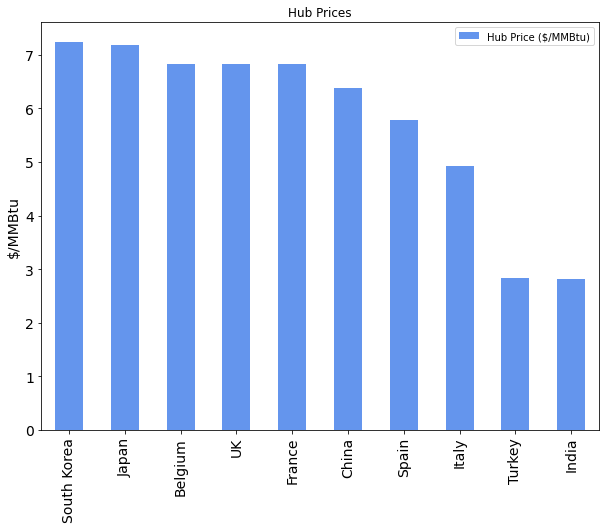

In [25]:
hp = Hub_Prices.T
hp.sort_values("Hub Price ($/MMBtu)", ascending=False, inplace = True)
ax = hp.plot(kind = 'bar', title = "Hub Prices", figsize = (10, 7.5), legend = True, fontsize = 14, color="cornflowerblue")
ax.set_xlabel("", fontsize=14)
ax.set_ylabel("$/MMBtu", fontsize=14)
plt.show()

## 5 Sensitivity analysis

### 5.1 Analysis by exporting nodes


In [26]:
if 'ok' == str(results.Solver.status):
    print("Exporter                   Supply           Shipped  Margin")
    print("\n")
    for m in model.src.keys():
        s = SRC[m-1]
        print("{0:17s}{1:15.1f}{2:17.1f}{3:10.4f}".format(s,Supply[s]/MMBtu_Gas/10**9,model.src[m]()/MMBtu_Gas/10**9,model.dual[model.src[m]]))
else:
    print("No Valid Solution Found")

Exporter                   Supply           Shipped  Margin


Qatar                      107.1            107.1   -3.7600
Australia                  104.7             66.6    0.0000
USA                         47.5             33.7    0.0000
Russia                      39.4             39.4   -1.8610
Malaysia                    35.1             35.1   -0.8040
Nigeria                     28.8             28.8   -2.0540
Trinidad & Tobago           17.0             17.0   -1.0210
Algeria                     16.9             16.9   -4.0940
Indonesia                   16.5             16.5   -0.7370
Oman                        14.1             14.1   -2.8210


Caution: The following discussion is based on the solutions of this particular (far from reality) model

The 'marginal' values are telling us how much the total (for all importing nodes) costs will be increased for each MMBtu increase in the available supply from each exporter. 

The optimization calculation says that approximately only 2/3 of the "available" LNG from Australia and USA should be used for a minimum cost solution, which rules out any further cost reductions by increasing the available supply in these two exporting nodes. In fact, the supply from these two nodes could be decreased without any harm (the marginal value of LNG from these 2 countries is 0).

Other exporting nodes are a different matter. First, all real export volumes are being used. Second, from the marginal value it can be seen that the total costs would be reduced by a certain value for each additional MMBtu of supply.

**Question:**

**Since this model doesn't contain all exporting and importing countries and their respective volumes of export and import (in 2019), should the available liquefaction capacity in each exporting node be used instead of the "available" supply???**

### 5.2 Analysis by importing nodes


In [27]:
if 'ok' == str(results.Solver.status):    
    print("Exporter              Demand    Shipped  Margin")
    print("\n")
    for n in model.dmd.keys():
        c = CUS[n-1]
        print("{0:12s}{1:15.1f}{2:10.1f}{3:10.4f}".format(c,Demand[c]/MMBtu_Gas/10**9,model.dmd[n]()/MMBtu_Gas/10**9,model.dual[model.dmd[n]]))
else:
    print("No Valid Solution Found")

Exporter              Demand    Shipped  Margin


Japan                 105.5     105.5    7.1290
China                  84.8      84.8    7.1470
South Korea            55.6      55.6    7.1880
India                  32.9      32.9    6.5570
France                 22.9      22.9    6.7620
Spain                  21.9      21.9    6.7590
UK                     18.0      18.0    6.7640
Italy                  13.5      13.5    6.9080
Turkey                 12.9      12.9    6.9060
Belgium                 7.2       7.2    6.7650


Looking at the demand constraints in each importing node, it can be seen that all of the required demands have been met by the optimal solution.

The marginal values of these constraints indicate how much the total costs of all importing nodes will increase if there is an additional MMBtu of demand at any of them. High marginal values indicate that importing nodes would get shipped additional volumes of LNG from exporters with high total costs of LNG.